In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Build Test Network

In [3]:
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,5*Nt,round(5*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 5000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

reload(network)

net = network.RingNetwork(NC=[NE,NI],Nori=Nori)
net.generate_disorder(1e-3*np.array([[0.15,-1],[0.8,-3]]),
                      np.array([[30,20],[30,20]]),
                      np.array([0.25,0.20]),
                      20*np.ones(2),500)
net.generate_tensors()

Loading previously saved nonlinearity
Using cpu
Using cpu


In [4]:
start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,net.M_torch,20*net.H_torch,net.H_torch,net.C_conds[0],
                             mult_tau=True,max_min=30)

print('integration took {:.3f} s'.format(time.process_time() - start))

dynas = sol[:,mask_time].numpy()
rates = np.mean(sol[:,mask_time].numpy(),-1)

integration took 62.155 s


60.391163
48.872913


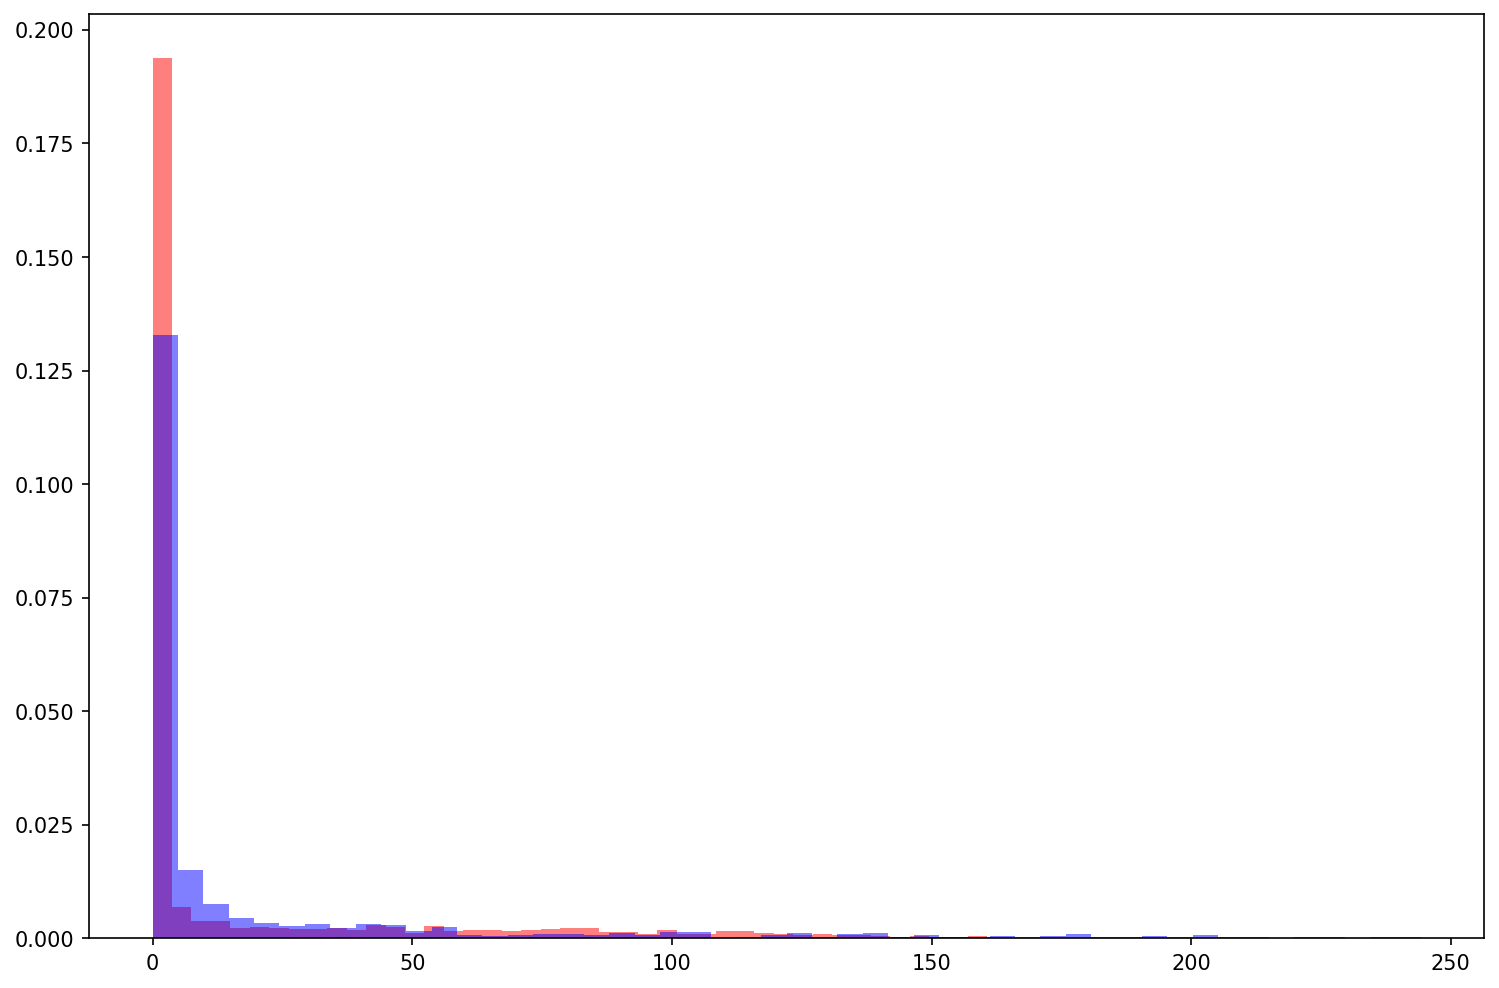

In [5]:
print(np.mean(rates[net.get_oriented_neurons()]))
print(np.std(rates[net.get_oriented_neurons()]))

fig,ax = plt.subplots(1,1,figsize=(12,8),dpi=150)

ax.hist(sol[net.C_all[0],-1],50,color='r',alpha=0.5,density=True)
ax.hist(sol[net.C_all[1],-1],50,color='b',alpha=0.5,density=True)

plt.show()

# Calculate Time-Averaged Jacobian

In [22]:
mus = 20*net.H[:,None] + net.M@dynas
mus[net.C_all[0]] = ri.tE*mus[net.C_all[0]]
mus[net.C_all[1]] = ri.tI*mus[net.C_all[1]]

gains = np.zeros_like(mus)
gains[net.C_all[0]] = ri.dphiE(mus[net.C_all[0]])
gains[net.C_all[1]] = ri.dphiE(mus[net.C_all[1]])

mus = np.mean(mus,-1)
gains = np.mean(gains,-1)

taus = np.zeros_like(mus)
taus[net.C_all[0]] = ri.tE
taus[net.C_all[1]] = ri.tI

inputs = 20*net.H

In [23]:
J = np.linalg.inv(np.eye(N) - (gains*taus)[:,None]*net.M) * ((gains*taus))[None,:]

In [24]:
U,S,Vh = np.linalg.svd(J)

In [62]:
rates_hat = rates/np.linalg.norm(rates)
inputs_hat = inputs/np.linalg.norm(inputs)
UTrates = U.T@rates_hat

In [63]:
rmetric = 0.5/np.dot(rates,rates)*Vh.T@(np.diag(S**2)-np.outer(S*UTrates,S*UTrates))@Vh
hmetric = 0.5/np.dot(inputs,inputs)*(np.eye(N)-np.outer(inputs_hat,inputs_hat))

In [64]:
evals,evecs = np.linalg.eig(rmetric)

Text(0, 0.5, 'Eigenvalue of r Metric / Eigenvalue of h Metric')

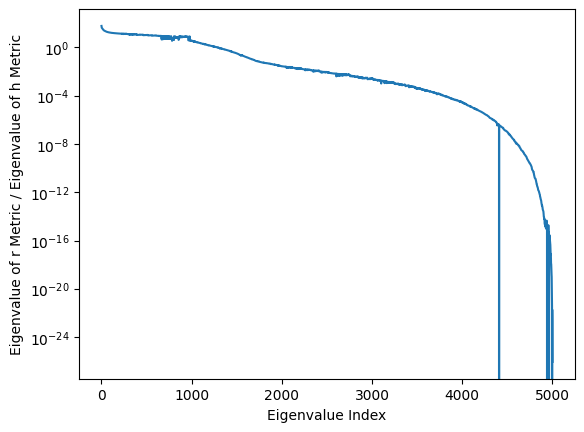

In [65]:
plt.plot(evals/np.diag(evecs.T@hmetric@evecs))
plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue of r Metric / Eigenvalue of h Metric')

In [66]:
np.mean(evals/np.diag(evecs.T@hmetric@evecs))

(2.3971412514707904-7.888609052210118e-35j)

In [67]:
np.mean(evals*2*np.inner(inputs,inputs))

(2.397125765246983+0j)

# Look at Input Correlations When Adding Noise

In [38]:
basefracs = np.arange(8+1)/8
corrs = np.linspace(0,1,21)[1:-1]
cvs = np.sqrt(1/(1-corrs)**2 - 1)
seeds = np.arange(50)

mean_inps = np.zeros((len(basefracs),N))
inps = np.zeros((len(basefracs),len(cvs),len(seeds),N))

for frac_idx,frac in enumerate(basefracs):
    mean_inps[frac_idx] = frac*np.max(net.H) + (1-frac)*net.H
    for cv_idx,cv in enumerate(cvs):
        shape = 1/cv**2
        scale = 1/shape
        for seed_idx,seed in enumerate(seeds):
            eps = np.random.default_rng(seed).gamma(shape,scale=scale,size=net.N).astype(np.float32)
            inps[frac_idx,cv_idx,seed_idx] = eps*mean_inps[frac_idx]

In [39]:
cos_sims = np.einsum('ij,iklj->ikl',mean_inps,inps)/\
    (np.linalg.norm(mean_inps,axis=-1)[:,None,None]*np.linalg.norm(inps,axis=-1))
pcorrs = np.array([[(np.sum(np.corrcoef(inps[frac_idx,cv_idx])) - len(seeds)) / (len(seeds)*(len(seeds)-1)) \
                    for cv_idx in range(len(cvs))] for frac_idx in range(len(basefracs))])
# pcorrs = np.array([[(np.sum(np.corrcoef(inps[frac_idx,cv_idx].T)) - N) / (N*(N-1)) \
#                     for cv_idx in range(len(cvs))] for frac_idx in range(len(basefracs))])

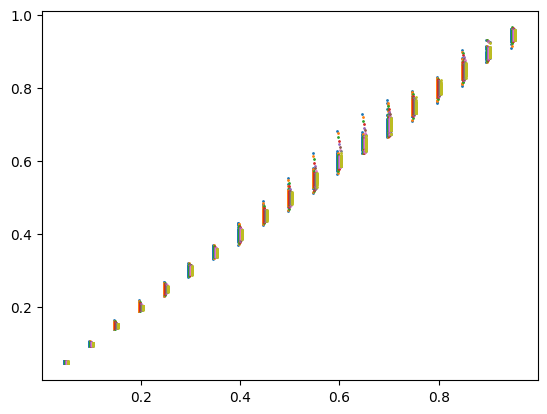

In [40]:
for frac_idx,frac in enumerate(basefracs):
    for cv_idx,corr in enumerate(corrs):
        plt.scatter(np.ones_like(seeds)*corr+0.001*(frac_idx-4),
                    1-cos_sims[frac_idx,cv_idx,:],c='C'+str(frac_idx),s=1)

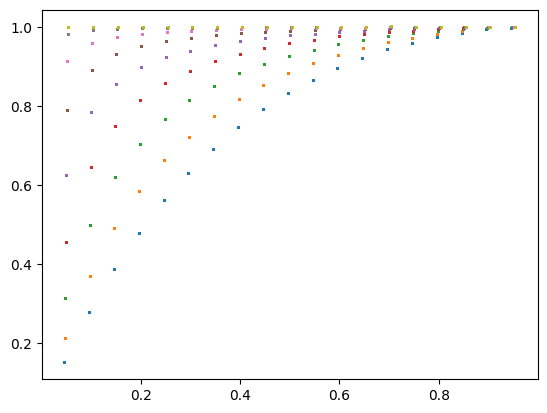

In [41]:
for frac_idx,frac in enumerate(basefracs):
    for cv_idx,corr in enumerate(corrs):
        plt.scatter(corrs+0.001*(frac_idx-4),
                    1-pcorrs[frac_idx,:],c='C'+str(frac_idx),s=1)

# Predict Slope of Curve from Jacobian Analysis

In [42]:
fluct_inps = (inps[0,0,:,:] - mean_inps[0]).T

In [43]:
np.mean(np.diag(fluct_inps.T@rmetric@fluct_inps)/\
        np.diag(fluct_inps.T@hmetric@fluct_inps))

8.266155287409157

# Plot Input vs Output Distances from Cluster Simulations

In [93]:
basefracs = np.arange(6+1)/6
disords = 50**(np.arange(0,6+1)/6)
corrs = np.linspace(0,1,21)[1:-1]
seeds = np.arange(5)

in_corrs = np.zeros((len(basefracs),len(disords),len(cvs),len(seeds)))
out_corrs = np.zeros((len(basefracs),len(disords),len(cvs),len(seeds)))

for c_idx in range(len(cvs)):
    with open('./../results/in_out_corrs_{:d}'.format(c_idx)+'.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
    in_corrs[:,:,c_idx,:] = res_dict['in_corrs']
    out_corrs[:,:,c_idx,:] = res_dict['out_corrs']

Text(0.5, 1.0, 'Toy Model')

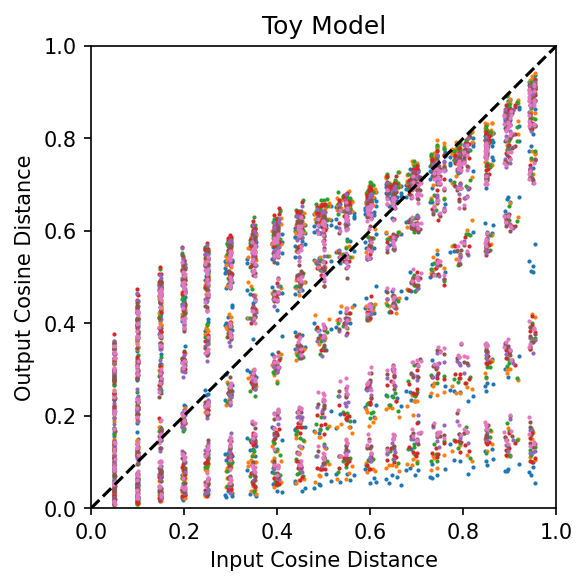

In [94]:
fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=150)

for frac_idx,frac in enumerate(basefracs):
    for dis_idx,dis in enumerate(disords):
        ax.scatter(in_corrs[frac_idx,dis_idx],out_corrs[frac_idx,dis_idx],c='C'+str(frac_idx),s=1)
    
ax.plot([0,1],[0,1],'k--')
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Input Cosine Distance')
ax.set_ylabel('Output Cosine Distance')
ax.set_title('Toy Model')

Text(0.5, 1.0, 'Toy Model')

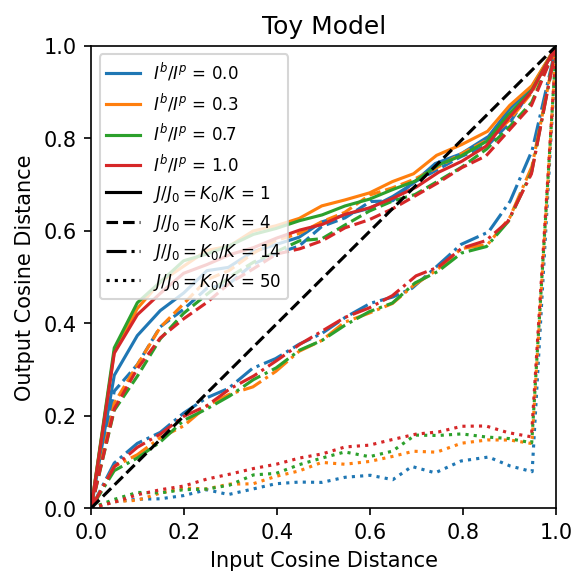

In [119]:
fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=150)

skip = 2

for frac_idx,frac in enumerate(basefracs[::skip]):
    for dis_idx,dis in enumerate(disords[::skip]):
        ax.plot(np.concatenate([[0,],np.mean(in_corrs[skip*frac_idx,skip*dis_idx],-1),[1,]]),
                np.concatenate([[0,],np.mean(out_corrs[skip*frac_idx,skip*dis_idx],-1),[1,]]),
                c='C'+str(frac_idx),ls=['-','--','-.',':'][dis_idx])#,
#                 label='baseline input/peak input = {:.1f}'.format(frac))

for frac_idx,frac in enumerate(basefracs[::skip]):
    ax.plot((-1),(-1),c='C'+str(frac_idx),label=r'$I^b/I^p$ = {:.1f}'.format(frac))
for dis_idx,dis in enumerate(disords[::skip]):
    ax.plot((-1),(-1),c='k',ls=['-','--','-.',':'][dis_idx],label=r'$J/J_0 = K_0/K$ = {:.0f}'.format(dis))
    
ax.plot([0,1],[0,1],'k--')
ax.legend(fontsize=8)
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Input Cosine Distance')
ax.set_ylabel('Output Cosine Distance')
ax.set_title('Toy Model')

In [44]:
np.mean(out_corrs[0],-1)[0]/corrs[0]

5.748640484543419

# Look at Best Fit Results

In [174]:
seeds = np.arange(5)

in_corrs = np.zeros((len(basefracs),len(cvs),len(seeds)))
out_corrs = np.zeros((len(basefracs),len(cvs),len(seeds)))

for c_idx in range(len(cvs)):
    with open('./../results/in_out_corrs_best_fit_{:d}'.format(c_idx)+'.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
    in_corrs[:,c_idx,:] = res_dict['in_corrs']
    out_corrs[:,c_idx,:] = res_dict['out_corrs']

Text(0.5, 1.0, 'Best Fit Model')

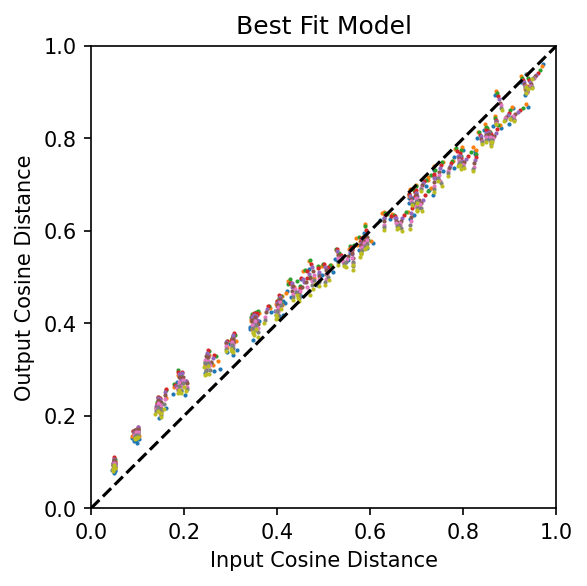

In [175]:
fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=150)

for frac_idx,frac in enumerate(basefracs):
    ax.scatter(in_corrs[frac_idx],out_corrs[frac_idx],c='C'+str(frac_idx),s=1)
    
ax.plot([0,1],[0,1],'k--')
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Input Cosine Distance')
ax.set_ylabel('Output Cosine Distance')
ax.set_title('Best Fit Model')

Text(0.5, 1.0, 'Best Fit Model')

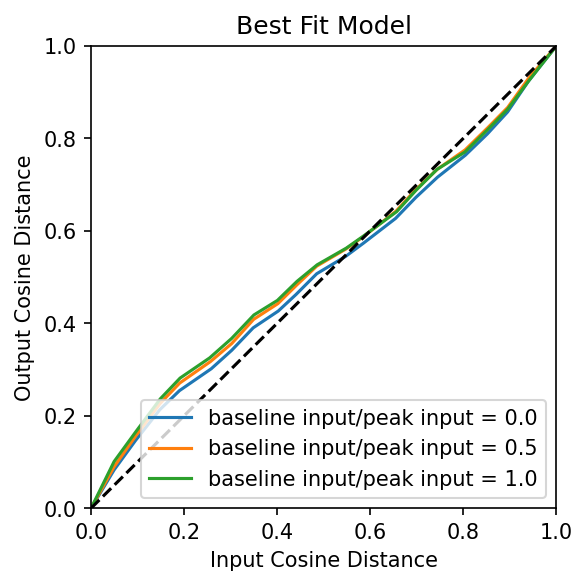

In [176]:
fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=150)

for frac_idx,frac in enumerate(basefracs[::4]):
    ax.plot(np.concatenate([[0,],np.mean(in_corrs[frac_idx],-1),[1,]]),
            np.concatenate([[0,],np.mean(out_corrs[frac_idx],-1),[1,]]),
            c='C'+str(frac_idx),label='baseline input/peak input = {:.1f}'.format(frac))
    
ax.plot([0,1],[0,1],'k--')
ax.legend()
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Input Cosine Distance')
ax.set_ylabel('Output Cosine Distance')
ax.set_title('Best Fit Model')